In [10]:
import seaborn as sns
import scipy as sp
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

wines = pd.read_csv('winequality-white.csv', sep=';')
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [11]:
#Reducing the number of quality classes from 6 to 3 to make classification easier
#0 being bad wine, 1 being average, 2 being great wine
wines_copy = wines.copy()

conditions = [
    wines_copy["quality"]>=7,
    (wines_copy["quality"]>=5) & (wines_copy["quality"]<7),
    (wines_copy["quality"]<5)
]

values = [2,1,0]
wines_copy["simple_quality"] = np.select(conditions, values)
wines_copy.drop("quality", axis = 1, inplace = True)

In [12]:
#Balancing Classes
X = wines_copy.drop("simple_quality", axis = 1)
y = wines_copy["simple_quality"]

ros = RandomOverSampler(random_state= 42)
X_res, y_res = ros.fit_resample(X, y)
X_new = pd.concat([X_res,y_res],axis = 1)

Accuracy :  0.9513677811550152 

************************************************************************************************************************
Confusion Matrix : 
 [[1168    0    0]
 [  23 1090  122]
 [   0   31 1185]]
************************************************************************************************************************
Classification Report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1168
           1       0.97      0.88      0.93      1235
           2       0.91      0.97      0.94      1216

    accuracy                           0.95      3619
   macro avg       0.95      0.95      0.95      3619
weighted avg       0.95      0.95      0.95      3619

************************************************************************************************************************


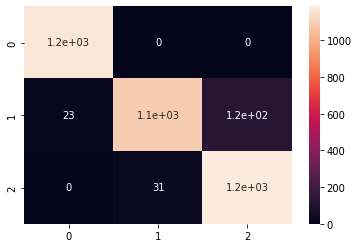

In [13]:
#Predicting quality with random forest
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42)

pipe = Pipeline([('scaler',StandardScaler()),('RF',RandomForestClassifier(n_estimators=30))])
pipe.fit(X_train, y_train)
pipe.predict(X_test)

#Accuracy score and confusion matrix
print('Accuracy : ', accuracy_score(y_test,pipe.predict(X_test)), '\n')
print('*' * 120)
print('Confusion Matrix : \n', confusion_matrix(y_test,pipe.predict(X_test)))
print('*' * 120)
print('Classification Report : ')
print(classification_report(y_test, pipe.predict(X_test))) 
print('*' * 120)
sns.heatmap(confusion_matrix(y_test,pipe.predict(X_test)), annot=True)

                 Feature  Importance
5    free sulfur dioxide   15.577504
10               alcohol   11.225419
1       volatile acidity   10.770285
7                density   10.116206
4              chlorides    8.369359
6   total sulfur dioxide    8.258248
3         residual sugar    7.850816
0          fixed acidity    7.571166
2            citric acid    7.515338
8                     pH    7.210908
9              sulphates    5.534750


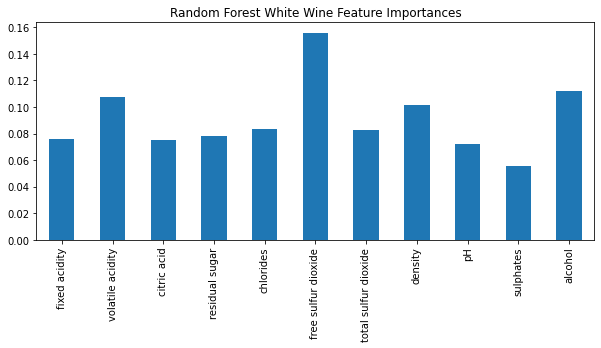

In [14]:
#Finding the importance of each from the random forest through mean decrease impurity
feature_names = [f"{i}" for i in wines_copy.columns[:-1]]
forest_importances = pd.Series(pipe[1].feature_importances_, index=feature_names)
featureImp= []

for feat, importance in zip(X_train.columns, pipe[1].feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
print(fT_df.sort_values('Importance', ascending = False))

forest_importances.plot.bar(figsize = (10,4))
plt.title("Random Forest White Wine Feature Importances")
plt.show()

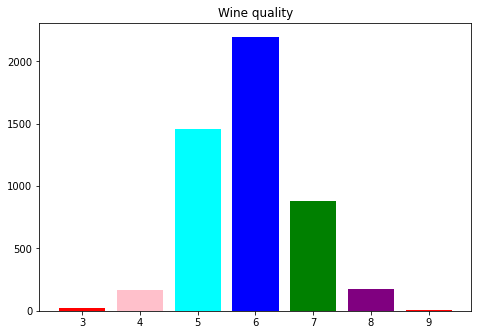

In [15]:
#Graph for distribution of wine quality
colors = ["red","pink","cyan","blue","green","purple"]

series = wines["quality"].value_counts()

sq = series.sort_index()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(sq.index,sq.values, color = colors)
ax.set_title("Wine quality")
plt.show()

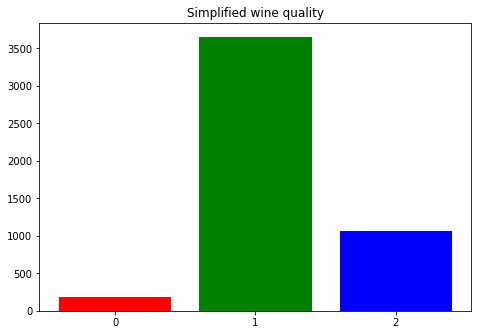

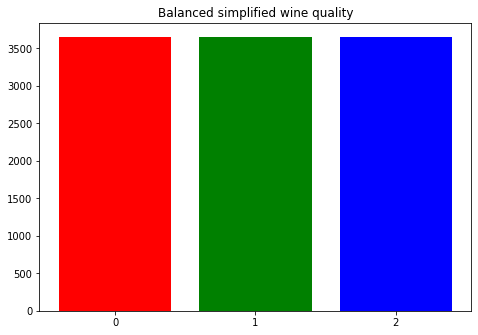

In [16]:
#Graph of simplified quality
colors1 = ["red","green","blue"]
series = wines_copy["simple_quality"].value_counts()
sq = series.sort_index()

fig = plt.figure()
qua = ["0","1","2"]
ax = fig.add_axes([0,0,1,1])
ax.bar(qua,sq.values, color = colors1)
ax.set_title("Simplified wine quality")

#Graph of balanced simplified quality
series = X_new["simple_quality"].value_counts()
sq = series.sort_index()

fig = plt.figure()
qua = ["0","1","2"]
ax = fig.add_axes([0,0,1,1])
ax.bar(qua,sq.values, color = colors1)
ax.set_title("Balanced simplified wine quality")
plt.show()

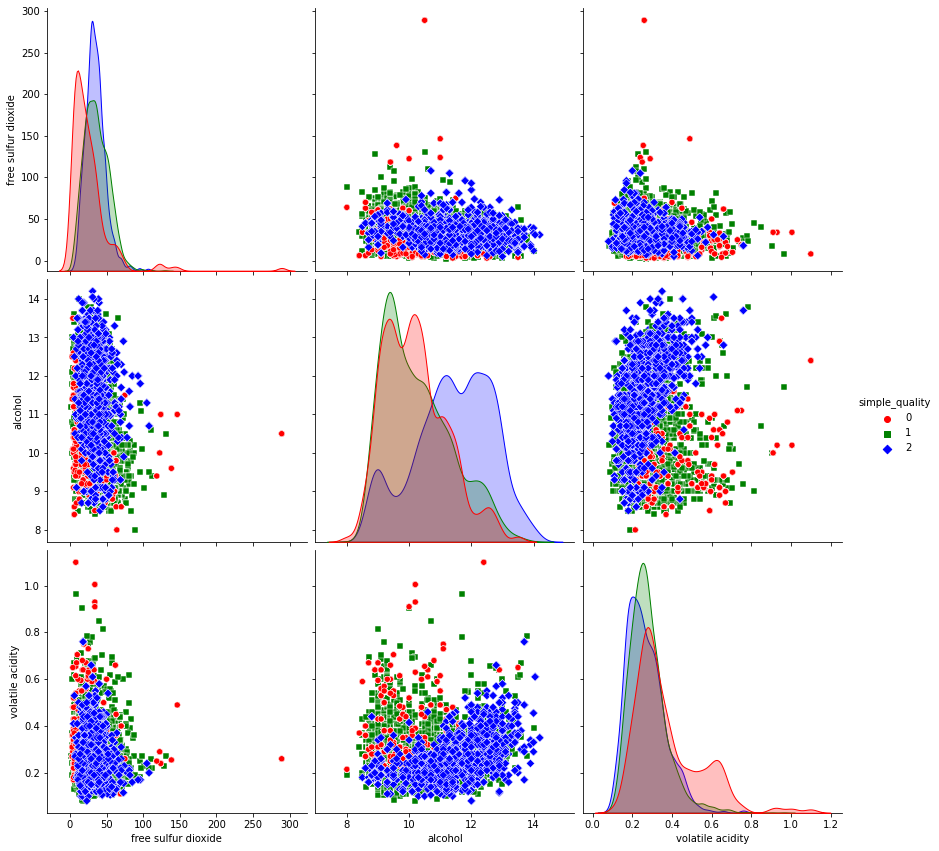

In [17]:
#Pairplot of the 3 most influencial classes
sns.pairplot(X_new[["free sulfur dioxide","alcohol","volatile acidity","simple_quality"]], hue = "simple_quality", palette = colors1, height = 4, markers = ["o","s","D"])
plt.show()